# Example 3: classify digits 0-9 using CNN followed by fully-connected layer using one-hot encoding of classes and softmax activation

### with help from:
* https://www.coursera.org/specializations/deep-learning homework
* https://liufuyang.github.io/2017/03/17/just-another-tensorflow-beginner-guide-2.html examples

In [1]:
import numpy as np
import tensorflow as tf
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datetime import datetime
import time

In [3]:
# use skikits learn helper function to split data
from sklearn.model_selection import train_test_split

In [4]:
# progress bar and loop timing
from tqdm import tnrange, tqdm_notebook

In [5]:
# helper function to read mnist data files
# from: https://github.com/zalandoresearch/fashion-mnist
import mnist_reader

In [6]:
# reset everything
tf.reset_default_graph()
np.random.seed(1)
seed = 3

In [7]:
# configuration
batch_size = 64
learning_rate = 0.001
training_epochs = 10

### functions

In [8]:
def random_mini_batches_img(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    
    from Andrew Ng - Coursera Deep Learning Specialization,
        https://www.coursera.org/specializations/deep-learning
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [9]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    
    from Andrew Ng - Coursera Deep Learning Specialization,
        https://www.coursera.org/specializations/deep-learning
    """
    
    # Create a tf.constant equal to C (depth), name it 'C'.
    C = tf.constant(C, name = "C")
    
    # Use tf.one_hot, be careful with the axis
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    # Create and run the session
    with tf.Session() as sess:
        one_hot = sess.run(one_hot_matrix)
    
    return one_hot

In [10]:
# modified from post: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def shuffle_in_unison(X, y):
    shuffled_X = np.empty(X.shape, dtype=X.dtype)
    shuffled_y = np.empty(y.shape, dtype=y.dtype)
    permutation = np.random.permutation(X.shape[0])
    for old_index, new_index in enumerate(permutation):
        shuffled_X[new_index,:,:] = X[old_index,:,:]
        shuffled_y[new_index,:] = y[old_index,:]
    return shuffled_X, shuffled_y

### load dataset

In [11]:
# these examples are gray scale images
nc = 1
# and are for 10 classes with one-hot encoding
n_classes = 10

# try this dataset
###############################################################
# ASL hand sign digits 0-9
# Turkey Ankara Ayrancı Anadolu High School's Sign Language Digits Dataset
# https://github.com/ardamavi/Sign-Language-Digits-Dataset
# converted to npy files by modifying this code: gist.github.com/ardamavi/get_dataset.py

# X_data = np.load('data/ASL-digits/ASL_X.npy').astype(np.float32)
# y_data = np.load('data/ASL-digits/ASL_Y.npy').astype(np.float32)
# y_data = one_hot_matrix(y_data,C=n_classes).T

# X_data, y_data = shuffle_in_unison(X_data,y_data) # this dataset is ordered, so must shuffle
# m,nh,nw = X_data.shape

# or this dataset
###############################################################
# MNIST handwritten digits 0-9: "Gradient-based learning applied to document recognition."
#   Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.    
#   Proceedings of the IEEE, 86(11):2278-2324, November 1998.
#   http://yann.lecun.com/exdb/mnist/
#
#   we are using only the train set here, and splitting it to train/test sets separately
# X_data, y_data = mnist_reader.load_mnist('data/mnist-digits', kind='train')

# or this dataset
###############################################################
# Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning 
#   Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747
#   https://github.com/zalandoresearch/fashion-mnist
#
#   we are using only the train set here, and splitting it to train/test sets separately
X_data, y_data = mnist_reader.load_mnist('data/mnist-fashion', kind='train')


# must normalize the data and convert labels to one-hot representation
X_data = X_data / 255.0
y_data = one_hot_matrix(y_data,C=n_classes).T

m,hxw = X_data.shape
nh = np.int(np.sqrt(hxw))
nw = np.int(np.sqrt(hxw))
X_data = np.reshape(X_data,(m,nh,nw))

In [12]:
print (X_data.shape)
print (y_data.shape)

# grayscale = one color channel
X_data = X_data.reshape(m,nh,nw,1)

(60000, 28, 28)
(60000, 10)


### take a look at one example

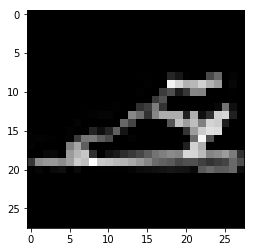

In [13]:
plt.imshow(X_data[300,:,:,0],cmap='gray')

In [14]:
print (y_data[300])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### split data into test / train sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.33, 
                                                    shuffle=True, random_state = 42)
num_examples = X_train.shape[0]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(40200, 28, 28, 1) (40200, 10)
(19800, 28, 28, 1) (19800, 10)


### use tensorflow index notation, keep as 2D images

In [16]:
# many data sets use X[m,nh,nw,nc] and tesnsorflow and scikits learn use m as first index
# keep this convention

### data input and formatted properly!

# CNN

start up tensorboard with 
$ tensorboard --logdir=./tmp/example --port=8002 --reload_interval=5

open browser at http://localhost:8002/ 
then you should be able to see the computation graph

In [17]:
# tensorboard log file path
logs_path = './tmp/example3/'+datetime.now().isoformat()

In [18]:
# reset everything
tf.reset_default_graph()
np.random.seed(1)
seed = 3

### tensorflow constants, variables, placeholders

In [19]:
with tf.name_scope('input'):
    X = tf.placeholder(tf.float32, shape=[None, nh, nw, nc], name="X")
    y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name="y_true")

In [20]:
with tf.name_scope('filterWeights'):
    W1 = tf.get_variable("W1", [4, 4, nc, 8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
# tensorflow's fully-connected function used here initializes its own weights automatically

### define computation graph

In [21]:
with tf.name_scope('convLayer1'):
    z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    a1 = tf.nn.relu(z1)
    p1 = tf.nn.max_pool(a1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
with tf.name_scope('convLayer2'):
    z2 = tf.nn.conv2d(p1, W2, strides=[1,1,1,1], padding='SAME')
    a2 = tf.nn.relu(z2)
    p2 = tf.nn.max_pool(a2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
with tf.name_scope('fullyConnected'):
    p2 = tf.contrib.layers.flatten(p2)
    z3 = tf.contrib.layers.fully_connected(p2, n_classes, activation_fn=None)
with tf.name_scope('softmax'):
    y  = tf.nn.softmax(z3)

### cost function

In [22]:
with tf.name_scope('cross_entropy'):
    cost = tf.reduce_mean(-tf.reduce_sum(y_true * tf.log(y)))

# this cross-entropy function does softmax automatically
# with tf.name_scope('cross_entropy'):
#     cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, \
#                                                                      logits=y))

### optimizer

In [23]:
with tf.name_scope('train'):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(cost)

### metrics

In [24]:
with tf.name_scope('accuracy'):
    correct_predictions = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))   
    accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

### log results

In [25]:
# summary for tensorboard
train_cost_summary = tf.summary.scalar("train_cost", cost)
train_accuracy_summary = tf.summary.scalar("train_accuracy", accuracy)

test_cost_summary = tf.summary.scalar("test_cost", cost)
test_accuracy_summary = tf.summary.scalar("test_accuracy", accuracy)

### main program

In [26]:
init = tf.global_variables_initializer()

In [27]:
with tf.Session() as sess:
    sess.run(init)
    
    # tensorboard log file writer    
    writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    batch_count = np.int(num_examples/batch_size)
    print ('number of mini_batches: ',batch_count)

    for epoch in tnrange(training_epochs, desc='epoch'):
        
        seed = seed+1
        mini_batches = random_mini_batches_img(X_train, y_train, batch_size, seed=seed)
        
        iter = 0        
        for mini_batch in mini_batches:
            
            iter = iter+1

            (batch_x, batch_y) = mini_batch
            
            _, train_cost, train_accuracy, _train_cost_summary, _train_accuracy_summary = \
               sess.run([train, cost, accuracy, train_cost_summary, train_accuracy_summary], \
                   feed_dict={X: batch_x, y_true: batch_y})
            
            writer.add_summary(_train_cost_summary, epoch * batch_count + iter)
            writer.add_summary(_train_accuracy_summary, epoch * batch_count + iter)
       
            if iter % 100 == 0:
                # for log on test data:
                test_cost, test_accuracy, _test_cost_summary, _test_accuracy_summary = \
                    sess.run([cost, accuracy, test_cost_summary, test_accuracy_summary], \
                        feed_dict={X:X_test, y_true:y_test})
                # write log
                writer.add_summary(_test_cost_summary, epoch * batch_count + iter)
                writer.add_summary(_test_accuracy_summary, epoch * batch_count + iter)
                
#                 print('Epoch {0:3d}, Batch {1:3d} | Train Cost: {2:.2f} | Test Cost: {3:.2f} | Train Accuracy: {4:.2f} | Test Accuracy: {5:.2f}'.format(epoch, iter, train_cost, test_cost, train_accuracy, test_accuracy))
            
    print('Final Test Set Accuracy: {}'.format(accuracy.eval(feed_dict={X:X_test, y_true:y_test})))

number of mini_batches:  628



Final Test Set Accuracy: 0.771212100982666
